In [2]:
%load_ext autoreload 
%autoreload 2
#!pip install googledrivedownloader
import tensorflow as tf
from keras import backend as bknd
import numpy as np
import datetime
import  matplotlib.pylab as plt
from remotedb import DB
from image_processor import    ltm_img_processor ,     real_images_processor
from models import ltm_predictor, discriminator
from tcng import predicted_images_generator, TCNNG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
batch_size= 2
#ltm ltm_predictor placeholders

tcn_pars={"batch_size":batch_size,"h":40,"w":500,"c":1,"lr":0.001,"op":"adam","lr_decay":0.9,
          "debug":0,"pathSaveModel":"data/logs/models/","load":"optimize_ltm_2019-04-16_05:49:00_0049-0.1954.hdf5",
          "stepepoch":1000,"epochs":50,"verbose":1,"tb_log_dir":"data/logs/tb"}
db_pars={"maxL":70,"hwprlabel":"lower","workspace_dir":"./data/workspace/",
         "google_file_id":"1l6sQMu4lOTGxHKqBhY9mXpI4Pd-Z6E_N",
         "google_file":"data/Approved_1_2_3_labled_v3.zip","dataset":"data/Approved_1_2_3_labled_v3/Approved",
         "p":.92,"hl":750,"wl":1600,"cl":1}
db_test_pars={"maxL":70,"hwprlabel":"lower","workspace_dir":"./data/workspace/",
         "google_file_id":"1nZwoUopM0Xk5qi3dIbJAzwB2KrvloGXc",
         "google_file":"data/test_dataset.zip","dataset":"data/test_dataset/Approved",
         "p":1,"hl":750,"wl":1600,"cl":1}


db = DB(db_pars)
db_test = DB(db_test_pars)



Total # of images in the dataset:  1492
Go for training 1372
Go for validating 120
Total # of images in the dataset:  188
Go for training 188
Go for validating 0


In [20]:
tf.reset_default_graph()
#training_graph=tf.Graph()
#testing_graph=tf.Graph()
#with training_graph.as_default():
#with tf.variable_scope("training") as scope:
tcng_tr = TCNNG(mydb=db, pars=tcn_pars,name='optimize_ltm')
ltm_images_ph_tr = tf.placeholder(tf.float32,[None, 124,124,1])
l_true_ph_tr = tf.placeholder(tf.float32,[None, 3])
l_pred_tr = ltm_predictor(ltm_images_ph_tr)          
tcng_tr.architechture(framework='tensorflow',l_pred=l_pred_tr)
#trainable_collection_tr = tf.get_collection_ref(tf.GraphKeys.TRAINABLE_VARIABLES)

#with testing_graph.as_default():
with tf.variable_scope("testing") as scope:
        tcng_ts = TCNNG(mydb=db, pars=tcn_pars,name='optimize_ltm')
        tcng_ts.batch_size=1
        ltm_images_ph_ts = tf.placeholder(tf.float32,[None, 124,124,1])
        l_pred_ts = ltm_predictor(ltm_images_ph_ts)          #reuse=True
        tcng_ts.architechture(framework='tensorflow',l_pred=l_pred_ts)

trainable_collection = tf.get_collection_ref(tf.GraphKeys.TRAINABLE_VARIABLES)

#[op.name for op in testing_graph.get_operations() if  'images_generator_func' in op.name ]#if op.op_def and op.op_def.name=='Variable'

#t_vars=tf.trainable_variables()
var_in_training= [var for var in trainable_collection if 'testing' not in var.name]
var_in_testing= [var for var in trainable_collection if 'testing' in var.name]


buckets len [257, 257, 257]
image.shapeimage.shape (630, 1364)
image.shapeimage.shape (601, 1437)
(4, 750, 1600, 1)
(4, 1)
(4, 1)
(4, 3)
(2, 124, 124, 1)
(2, 3)
(4, 70)
(4, 1)


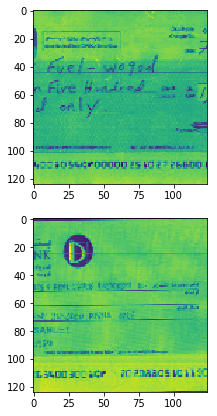

In [19]:
train_gen = db.main_generator(tr=True, batch_size=batch_size)
test_gen = db.main_generator(tr=True, batch_size=1)
(images, heights, widths, lines,labels,seq_lens), _ = next(train_gen)
ltm_images, l_true = ltm_img_processor(images, heights, widths,lines,double=False)
print(images.shape)
print(heights.shape)
print(widths.shape)
print(lines.shape)
print(ltm_images.shape)
print(l_true.shape)
print(labels.shape)
print(seq_lens.shape)
plt.figure(figsize=(40,30))
for j in range(int(1*2)):
    plt.subplot(8,1,j+1)
    #plt.title(''.jon([db.Ivoc[i] for i in out[j] if i in  db.Ivoc.keys()]))
    img = np.squeeze(ltm_images[j])
    shape = img.shape
    img = img.reshape(shape[0], shape[1])
        
    plt.imshow(img)


INFO:tensorflow:Restoring parameters from ./ltm_predictor_vanila-1000
Model restored.
False P: ou thousand seved hudred and eighty woonly , T: four thousand seven hundred and eighty two only
8.460099


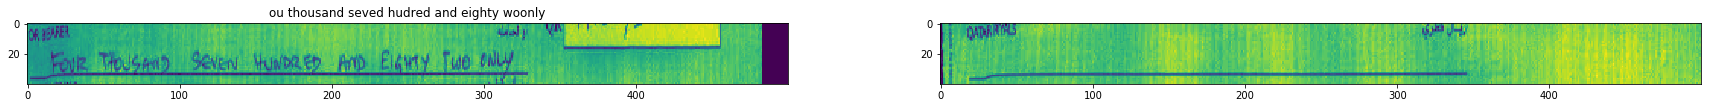

In [27]:
#tcng.model.summary()
from EvaluateTCN import compare
#with training_graph.as_default():

    
tvars = tf.trainable_variables()

p_vars = [var for var in tvars if 'p_' in var.name and 'testing' not in var.name]

saver = tf.train.Saver(p_vars)

(images, heights, widths, lines,labels,seq_lens), _ = next(train_gen)
ltm_images, l_true = ltm_img_processor(images, heights, widths,lines,double=False)
with tf.Session() as sess:
    # Restore variables from disk.
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./ltm_predictor_vanila-1000",)
    print("Model restored.")

    
    l_p , p_images, y_pred , ctc_loss  = sess.run([l_pred_tr,tcng_tr.predicted_images,tcng_tr.fc_2,
                                                   tcng_tr.loss_out],feed_dict={ltm_images_ph_tr:ltm_images,
                                           tcng_tr.images_ph:images,
                                           tcng_tr.heights_ph: heights,
                                           tcng_tr.widths_ph:widths,
                                           tcng_tr.labels:labels,
                                           tcng_tr.label_length:seq_lens})
    
    
    tcng_tr.model.load_weights("data/logs/models/"+tcn_pars["load"])
    for var_idx, var in enumerate(var_in_testing):
        #print("var_in_testing[var_idx]",var_in_testing[var_idx])
        #print("var_in_training[var_idx]",var_in_training[var_idx])
        var_in_testing[var_idx].load(var_in_training[var_idx].eval(),sess)

        
    (images, heights, widths, lines,labels,seq_lens), _ = next(test_gen)
    ltm_images, l_true = ltm_img_processor(images, heights, widths,lines,double=False)
    #tcng_tr.model.load_weights("data/logs/models/"+tcn_pars["load"])
    l_p , p_images, y_pred , ctc_loss  = sess.run([l_pred_ts,tcng_ts.predicted_images,tcng_ts.fc_2,
                                                   tcng_ts.loss_out],feed_dict={ltm_images_ph_ts:ltm_images,
                                           tcng_ts.images_ph:images,
                                           tcng_ts.heights_ph: heights,
                                           tcng_ts.widths_ph:widths,
                                           tcng_ts.labels:labels,
                                           tcng_ts.label_length:seq_lens})


    shape = y_pred[:, 2:, :].shape 
    ctc_decode = bknd.ctc_decode(y_pred[:, 2:, :], input_length=np.ones(shape[0])*shape[1])[0][0]
    out = bknd.get_value(ctc_decode)[:, :db.maxL]

ler, results = compare(out, labels, db.Ivoc, show=len(out)-1)
    
print(np.mean(ctc_loss))
#print(out)
#print(l_p)
#print(ler)
#print(results)

plt.figure(figsize=(30,15))
for j in range(int(1*2)):
    plt.subplot(8,2,j+1)
    plt.title(''.join([db.Ivoc[i] for i in out[j] if i in  db.Ivoc.keys()]))
    img = np.squeeze(p_images[j])
    shape = img.shape
    img = img.reshape(shape[0], shape[1])
        
    plt.imshow(img)

In [1]:
%load_ext autoreload 
%autoreload 2
import tensorflow as tf
from keras import backend as bknd
import numpy as np
import datetime
import  matplotlib.pylab as plt
from remotedb import DB
from image_processor import    ltm_img_processor ,     real_images_processor
from models import ltm_predictor, discriminator
from tcng import predicted_images_generator, TCNNG
from EvaluateTCN import compare
import logging
#####################################333
batch_size= 2
#ltm ltm_predictor placeholders

tcn_pars={"batch_size":batch_size,"h":40,"w":500,"c":1,"lr":0.001,"op":"adam","lr_decay":0.9,
          "debug":0,"pathSaveModel":"data/logs/models/","load":"optimize_ltm_2019-04-16_05:49:00_0049-0.1954.hdf5",
          "stepepoch":1000,"epochs":50,"verbose":1,"tb_log_dir":"data/logs/tb"}
db_pars={"maxL":70,"hwprlabel":"lower","workspace_dir":"./data/workspace/",
         "google_file_id":"1l6sQMu4lOTGxHKqBhY9mXpI4Pd-Z6E_N",
         "google_file":"data/Approved_1_2_3_labled_v3.zip","dataset":"data/Approved_1_2_3_labled_v3/Approved",
         "p":.92,"hl":750,"wl":1600,"cl":1}
db_test_pars={"maxL":70,"hwprlabel":"lower","workspace_dir":"./data/workspace/",
         "google_file_id":"1nZwoUopM0Xk5qi3dIbJAzwB2KrvloGXc",
         "google_file":"data/test_dataset.zip","dataset":"data/test_dataset/Approved",
         "p":1,"hl":750,"wl":1600,"cl":1}


db = DB(db_pars)
db_test = DB(db_test_pars)

############################################
#tf.reset_default_graph()

#ltm_images_ph = tf.placeholder(tf.float32,[None, 124,124,1])
#l_true_ph = tf.placeholder(tf.float32,[None, 3])
#l_pred = ltm_predictor(ltm_images_ph)          

#tcng = TCNNG(mydb=db, pars=tcn_pars,name='optimize_ltm')
#loss_out, fc_2 = tcng.architechture(framework='tensorflow',l_pred=l_pred)


tf.reset_default_graph()
tcng_tr = TCNNG(mydb=db, pars=tcn_pars,name='optimize_ltm')
ltm_images_ph_tr = tf.placeholder(tf.float32,[None, 124,124,1])
l_true_ph_tr = tf.placeholder(tf.float32,[None, 3])
l_pred_tr = ltm_predictor(ltm_images_ph_tr)          
tcng_tr.architechture(framework='tensorflow',l_pred=l_pred_tr)

with tf.variable_scope("testing") as scope:
        tcng_ts = TCNNG(mydb=db, pars=tcn_pars,name='optimize_ltm')
        tcng_ts.batch_size=1
        ltm_images_ph_ts = tf.placeholder(tf.float32,[None, 124,124,1])
        l_pred_ts = ltm_predictor(ltm_images_ph_ts)         
        tcng_ts.architechture(framework='tensorflow',l_pred=l_pred_ts)

trainable_collection = tf.get_collection_ref(tf.GraphKeys.TRAINABLE_VARIABLES)


var_in_training = [var for var in trainable_collection if 'testing' not in var.name]
var_in_testing = [var for var in trainable_collection if 'testing' in var.name]
####################################
p_mse_loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=l_true_ph_tr, predictions=l_pred_tr,weights=1.0), name='p_mse_loss')
ctc_loss = tf.reduce_mean(tf.multiply(tf.constant(0.00002),tcng_tr.loss_out), name='ctc_loss')
p_total_loss = tf.add( p_mse_loss,ctc_loss, name='p_total_loss')
p_mse_metric = tf.reduce_mean(tf.metrics.mean_squared_error(labels=l_true_ph_tr, predictions=l_pred_tr,weights=1.0),name='p_mse_metric')

tvars = tf.trainable_variables()
p_vars = [var for var in tvars if 'p_' in var.name and 'testing' not in var.name]
p_total_trainer = tf.train.AdamOptimizer(0.0001).minimize(p_total_loss,var_list=p_vars)

##############
tf.summary.scalar('predictor_mse_loss_train',p_mse_loss)
tf.summary.scalar('ctc_loss_train',ctc_loss)
tf.summary.scalar('predictor_total_loss_train',p_total_loss)

tf.summary.image('predicted_images_generator',tcng_tr.predicted_images,5)


merged = tf.summary.merge_all()

p_mse_loss_valid_summary = tf.summary.scalar('predictor_mse_loss_valid',p_mse_loss)
p_ctc_loss_valid_summary = tf.summary.scalar('ctc_loss_valid',ctc_loss)
p_total_loss_valid_summary = tf.summary.scalar('predictor_total_loss_valid',p_total_loss)
p_mse_metric_valid_summary = tf.summary.scalar('predictor_mse_metric_valid',p_mse_metric)
merged_valid = tf.summary.merge([p_mse_loss_valid_summary,p_ctc_loss_valid_summary,
                                 p_total_loss_valid_summary,p_mse_metric_valid_summary])


logdir = "data/logs/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
############################
train_gen = db.main_generator(tr=True, batch_size=batch_size)
valid_gen = db.main_generator(tr=False, batch_size=batch_size)
test_gen = db_test.main_generator(tr=True, batch_size=1)


Using TensorFlow backend.


Total # of images in the dataset:  1492
Go for training 1372
Go for validating 120
Total # of images in the dataset:  188
Go for training 188
Go for validating 0


0
81
0
163
0
123
2
229
1
4
1
7
Iteration: 0 at 2019-05-11 01:18:31.413675
0
14
0
28


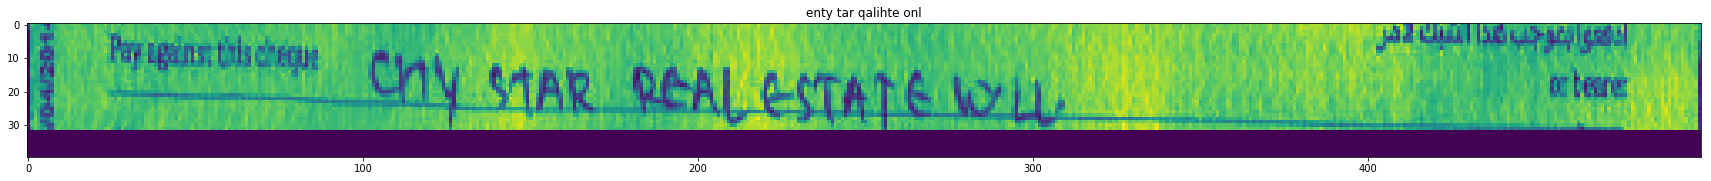

0
4
2
211
2
450
1
440
0
218
2
205
2
121
0
152
2
523
2
333
1
84
2
234
1
68
1
50
1
450
2
233
0
9
0
235
2
244
2
623
0
85
0
207
0
28
2
49
0
245
2
136
0
134
1
65
1
244
1
319
0
234
0
86
0
150
0
162
0
33
0
6
0
5
0
150
0
151
1
104
2
547
0
44
1
298
2
126
0
81
2
360
0
29
1
28
2
49
1
175
2
218
2
109
1
312
0
165
2
544
1
43
1
210
2
215
0
61
1
370
2
317
1
198
1
419
0
47
1
424
2
418
2
8
2
469
0
44
0
231
0
6
0
25
0
2
2
383
1
422
0
245
0
134
2
376
0
217
0
51
2
114
0
199
1
115
0
64
2
43
2
470
1
124
1
260
1
355
1
74
2
614
1
40
1
245
2
667
2
31
1
7
0
25
0
69
0
237
1
280
2
491
1
315
1
197
1
179
2
502
2
600
1
90
2
137
0
23
2
596
0
226
1
387
2
445
2
205
2
212
2
32
1
24
1
236
2
12
1
28
0
182
1
233
2
1
0
225
1
91
0
92
2
354
2
441
0
185
2
550
2
244
1
202
2
99
1
207
2
56
2
357
0
57
0
243
2
96
0
40
2
525
2
480
0
29
0
7
2
614
2
57
2
263
2
665
2
106
2
144
1
405
0
63
2
59
2
649
1
15
2
440
1
180
2
465
0
29
1
298
1
56
0
77
2
126
1
125
2
595
1
327
0
18
2
53
2
576
2
610
1
188
0
237
0
28
1
434
2
54
1
310
0
95
1
219
1
345

KeyboardInterrupt: 

In [2]:
!rm -rf data/logs/evaluate.out
#!rm -rf data/logs/ltm_models
!rm -rf data/logs/tensorboard

logging.basicConfig(filename='data/logs/evaluate.out',level=logging.DEBUG ,format='%(asctime)s %(levelname)s %(message)s')
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    writer =tf.summary.FileWriter(logdir,sess.graph)

    tcng_tr.model.load_weights("data/logs/models/"+tcn_pars["load"])
    newler = 999999999999.99
    # Train ltm_predictor and discriminator together
    for i in range(66000):
        #images, lines , ids = next(train_gen)
        #images = np.array(images)
        #ltm_images, l_true = ltm_img_processor(images,lines)
        #real_images =  real_images_processor(images, lines)


        # Train discriminator on both real and fake images
        ##_, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
        ##                                       {real_images_ph:real_images ,images_ph:images, ltm_images_ph:ltm_images })


        # Train ltm_predictor

        #images, heights, widths, lines , ids = next(train_gen)
        (images, heights, widths, lines,labels,seq_lens), _ = next(train_gen)
        ltm_images, l_true = ltm_img_processor(images, heights, widths,lines,double=False)
        
        #images = np.array(images)
        #ltm_images, l_true = ltm_img_processor(images, heights, widths, lines)
        #_ = sess.run(p_total_trainer, feed_dict={images_ph:images, ltm_images_ph:ltm_images, l_true_ph:l_true })

        _ = sess.run(p_total_trainer,
                     feed_dict={ltm_images_ph_tr:ltm_images,
                                l_true_ph_tr:l_true,                                                                               
                                tcng_tr.images_ph:images,
                                tcng_tr.heights_ph:heights,
                                tcng_tr.widths_ph:widths,
                                tcng_tr.labels:labels,
                                tcng_tr.label_length:seq_lens})

        if i % 10 == 0:
            # Update TensorBoard with summary statistics
            (images, heights, widths, lines,labels,seq_lens), _ = next(train_gen)
            ltm_images, l_true = ltm_img_processor(images, heights, widths,lines,double=False)

            summary = sess.run(merged, feed_dict={ltm_images_ph_tr:ltm_images,
                                                  l_true_ph_tr:l_true,                                                                               
                                                  tcng_tr.images_ph:images,
                                                  tcng_tr.heights_ph: heights,
                                                  tcng_tr.widths_ph:widths,
                                                  tcng_tr.labels:labels,
                                                  tcng_tr.label_length:seq_lens})
            writer.add_summary(summary, i)



            (images, heights, widths, lines,labels,seq_lens), _ = next(valid_gen)
            ltm_images, l_true = ltm_img_processor(images, heights, widths,lines,double=False)


            summary = sess.run(merged_valid, feed_dict={ltm_images_ph_tr:ltm_images,
                                                  l_true_ph_tr:l_true,                                                                               
                                                  tcng_tr.images_ph:images,
                                                  tcng_tr.heights_ph: heights,
                                                  tcng_tr.widths_ph:widths,
                                                  tcng_tr.labels:labels,
                                                  tcng_tr.label_length:seq_lens})
            writer.add_summary(summary, i)
        
        
        #gstep = tf.train.get_global_step(graph=tf.get_default_graph())
        
        if i % 5000 == 0 and i!=0:
            logging.info("start evaluation at global_step: %i",i)
            
            
            for var_idx, var in enumerate(var_in_testing):
                var_in_testing[var_idx].load(var_in_training[var_idx].eval(),sess)
            logging.info("Testing variables are loaded")
            
            
            tler = db_test.evaluate2(ltm_images_ph_ts,tcng_ts,sess)
            if tler <= newler:
                logging.info("ler is improved from from %f to %f",newler, tler)
                newler = tler
                
                p_vars = [var for var in var_in_training if 'p_' in var.name]
                saver = tf.train.Saver(var_list=p_vars)
                
                saver.save(sess, "./data/logs/ltm_models/ltm_predictor_only_tler_"+str(tler), global_step=i, write_meta_graph=True)
                logging.info("save model tm_predictor_only_tler_"+str(tler))
                
            else:
                logging.info("ler is not improved from from %f to %f",newler, tler)

                
                
            
            
            

            
            
        if i % 150 == 0:
            # Every 100 iterations, show a predicted image
            print("Iteration:", i, "at", datetime.datetime.now())
            (images, heights, widths, lines,labels,seq_lens), _ = next(valid_gen)
            ltm_images, l_true = ltm_img_processor(images, heights, widths,lines,double=False)

            p_images, y_pred= sess.run([tcng_tr.predicted_images,tcng_tr.fc_2],
                                       feed_dict={ltm_images_ph_tr:ltm_images,
                                                  tcng_tr.images_ph:images,
                                                  tcng_tr.heights_ph: heights,
                                                  tcng_tr.widths_ph:widths})
            shape = y_pred[:, 2:, :].shape 
            ctc_decode = bknd.ctc_decode(y_pred[:, 2:, :], input_length=np.ones(shape[0])*shape[1])[0][0]
            out = bknd.get_value(ctc_decode)[:, :db.maxL]

            ler, results = compare(out, labels, db.Ivoc, show=batch_size)


            plt.figure(figsize=(30,15))
            #for j in range(int(batch_size/2)):
            #plt.subplot(8,2,0+1)
            plt.title(''.join([db.Ivoc[i] for i in out[0] if i in  db.Ivoc.keys()]))
            img = np.squeeze(p_images[0])
            shape = img.shape
            img = img.reshape(shape[0], shape[1])
            plt.imshow(img)
            plt.show()




In [ ]:

tvars = tf.trainable_variables()
p_vars = [var for var in tvars if 'p_' in var.name]
saver = tf.train.Saver(var_list=p_vars)
saver.save(sess, "./ltm_predictor_only", global_step=1000, write_meta_graph=True)



In [ ]:
tvars = tf.trainable_variables()
p_vars = [var for var in tvars if 'p_' not in var.name]
saver = tf.train.Saver(var_list=p_vars)
saver.save(sess, "./hw_only", global_step=1000, write_meta_graph=True)


In [ ]:
saver = tf.train.Saver()
saver.save(sess, "./all", global_step=1000, write_meta_graph=True)


In [ ]:
!shutdown